In [1]:
import networkx as nx
from wordcloud import WordCloud
from PIL import Image
from colour import Color
import pandas as pd
import re
import numpy as np
import io
import nltk
import json

## Loading in data

In [2]:
df = pd.read_csv('starwarscharacters.csv')

## Building the graph

In [3]:
G = nx.DiGraph()

#Adding the nodes
for i in range(len(df)):
    name = df.loc[i]['name']
    species = df.loc[i]['species']
    goodness = df.loc[i]['goodness']
    G.add_node(name, goodness=goodness, species=species)
    
#Adding the edges
for i in range(len(df)):
    name = df.loc[i]['name']
    fileName = name.replace(" ", "_") + ".txt"
    text = open("./Wookiepediafiles/" + fileName, "r").read()
    #Finding the links in the Wookieepedia article
    links = re.findall('\[\[(.*?)\]\]', text)
    for link in links:
        for l in link.split("|"):
            # Only add edge if it does not exist, remove self-loops, only take links that are characters
            if l in list(df['name']) and name != l:
                if not G.has_edge(name, l):
                    G.add_edge(name, l)
                break

print("Amount of nodes: %s" % G.number_of_nodes())
print("Amount of edges: %s" % G.number_of_edges())

Amount of nodes: 407
Amount of edges: 5086


# Plotting the graph

In [4]:
# Draw network
%matplotlib inline
from fa2 import ForceAtlas2
import matplotlib
import matplotlib.pyplot as plt

G_undir = G.to_undirected()

# set up forceatlas2 parameters
forceatlas2 = ForceAtlas2(# Behavior alternatives
                          outboundAttractionDistribution=False,  # Dissuade hubs
                          linLogMode=False,
                          adjustSizes=False,
                          edgeWeightInfluence=1.0,

                          # Performance
                          jitterTolerance=1.0,  # Tolerance
                          barnesHutOptimize=False,
                          barnesHutTheta=1.2,
                          multiThreaded=False,  # NOT IMPLEMENTED

                          # Tuning
                          scalingRatio=1.0,
                          strongGravityMode=False,
                          gravity=100.0,
                          # Log
                          verbose=True)
positions = forceatlas2.forceatlas2_networkx_layout(G_undir, pos=None, iterations=25000)

100%|██████████| 25000/25000 [00:28<00:00, 891.29it/s]

('Repulsion forces', ' took ', '14.85', ' seconds')
('Gravitational forces', ' took ', '0.62', ' seconds')
('Attraction forces', ' took ', '1.44', ' seconds')
('AdjustSpeedAndApplyForces step', ' took ', '3.19', ' seconds')


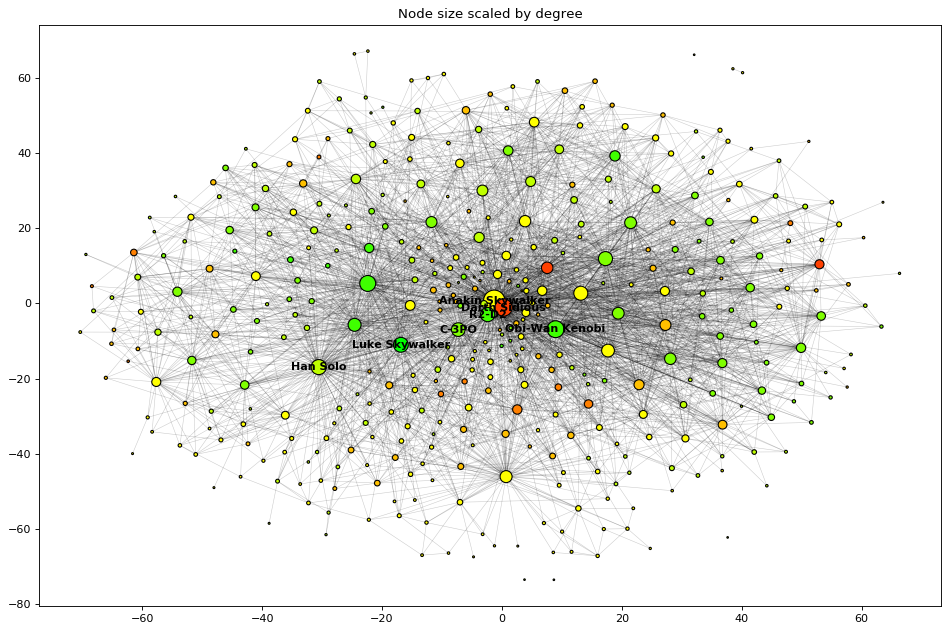

In [5]:
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title("Node size scaled by degree")

sizemap_degree = []
colormap = []
colors = ["red", "yellow", "green"]
red = 255
green = 0
stepSize = 64 
colorScale = []
while green < 255 :
    green += stepSize
    if green > 255 : 
        green = 255
    colorScale.append(('#%02x%02x%02x' % (red, green, 0)))

while(red > 0) :
    red -= stepSize
    if red < 0 :
        red = 0
    colorScale.append(('#%02x%02x%02x' % (red, green, 0)))


for node in G_undir:
    sizemap_degree.append(G.degree(node) + 2)
    idx = G.node[node]['goodness']+3
    colormap.append(colorScale[idx])

nodelist = [node for node in G_undir.nodes]
edgelist = [edge for edge in G_undir.edges]
nx.draw_networkx_nodes(G_undir, positions, with_labels=False, nodelist=nodelist, node_color=colormap, edgecolors="black", node_size=sizemap_degree)
nx.draw_networkx_edges(G_undir, positions, alpha=0.2, edge_color="black", width=0.5, edgelist=edgelist)


labelNodes = ["Anakin Skywalker", "Obi-Wan Kenobi", "R2-D2", "C-3PO", "Darth Sidious", "Luke Skywalker", "Han Solo"]
labels = {}
for node in nodelist :
    if node in labelNodes :
        labels[node] = node
    else :
        labels[node] = ""
            
nx.draw_networkx_labels(G_undir,pos=positions, labels = labels, font_color = "black", font_weight = "bold", font_size=10)
plt.tight_layout()
plt.savefig('docs/img/graph.png', transparent=True)
plt.show()

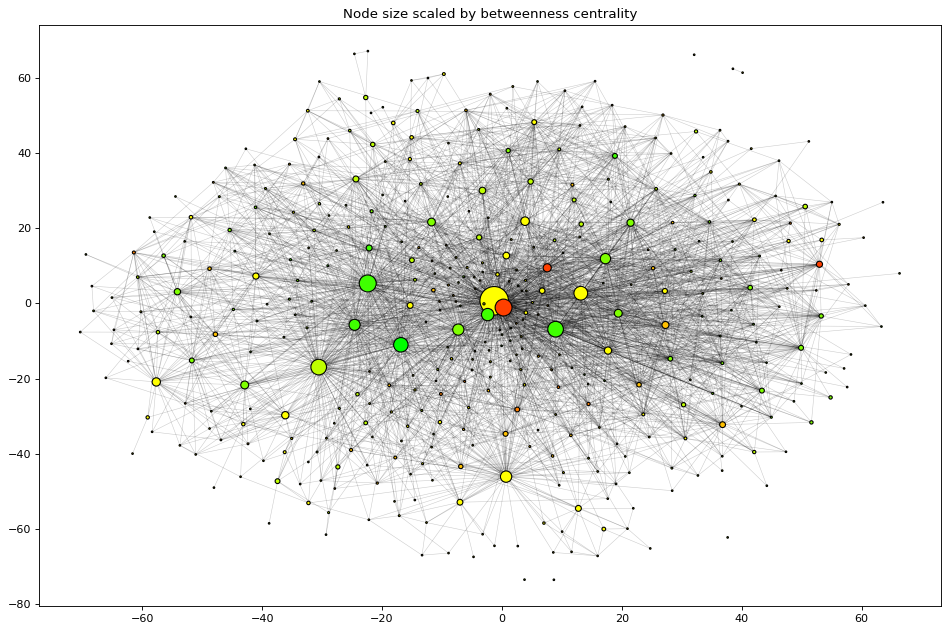

In [6]:
btw_cnt = nx.betweenness_centrality(G)
btw_cnt = list(map(lambda n: btw_cnt[n], nodelist))

plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title("Node size scaled by betweenness centrality")
scale_node = 3000
nx.draw_networkx_nodes(G_undir, positions, with_labels=False, nodelist=nodelist,
                       node_color=colormap, edgecolors="black", node_size=list(map(lambda x: 2+x*scale_node, btw_cnt)) )
nx.draw_networkx_edges(G_undir, positions, edge_color="black", alpha=0.2, width=0.5)
plt.tight_layout()
plt.savefig('docs/img/between.png', transparent=True)
plt.show()

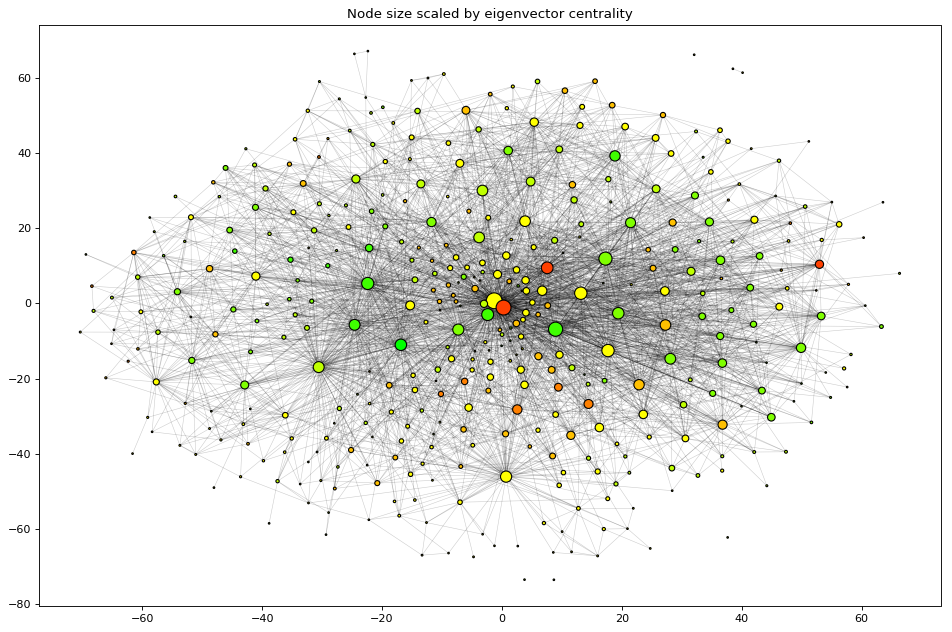

In [7]:
eig_cnt = nx.eigenvector_centrality(G)
eig_cnt = list(map(lambda n: eig_cnt[n], nodelist))

plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title("Node size scaled by eigenvector centrality")
scale_node = 700
nx.draw_networkx_nodes(G_undir, positions, with_labels=False, nodelist=nodelist, node_color=colormap,
                       edgecolors="black", node_size=list(map(lambda x: 2+x*scale_node, eig_cnt)) )
nx.draw_networkx_edges(G_undir, positions, edge_color="black", alpha=0.2, width=0.5)
plt.tight_layout()
plt.savefig('docs/img/eigen.png', transparent=True)
plt.show()

In [8]:
in_degrees = [G.in_degree(x) for x in G.nodes()]
out_degrees = [G.out_degree(x) for x in G.nodes()]
degrees = [G.degree(x) for x in G.nodes()]

degrees_names = sorted(G.nodes, key=lambda x: G.degree(x), reverse=True)
out_degrees_names = sorted(G.nodes, key=lambda x: G.out_degree(x), reverse=True)
in_degrees_names = sorted(G.nodes, key=lambda x: G.in_degree(x), reverse=True)
goodness_names = sorted (G.nodes, key=lambda x: G.node[x]['goodness'], reverse=True)
print(degrees_names[:5])

['Anakin Skywalker', 'Darth Sidious', 'Obi-Wan Kenobi', 'Leia Organa', 'Han Solo']


# Community Detection


In [10]:
from community import community_louvain

partition = community_louvain.best_partition(G_undir)
print
print("Value of modularity: %s" % community_louvain.modularity(partition, G_undir))


Value of modularity: 0.366319908612


Amount of communities: 9


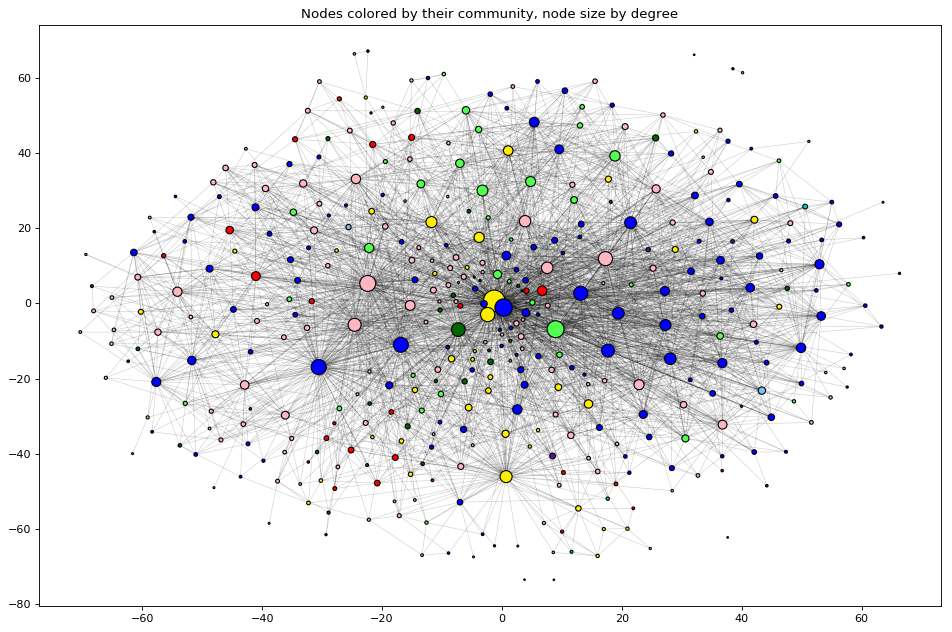

In [11]:
import random
# We set the colors for each community
size = float(len(set(partition.values())))
communities = []
for com in set(partition.values()):
    list_nodes = [node for node in partition.keys()
                                if partition[node] == com]
    if len(list_nodes) > 1:
        communities.append(list_nodes)
    
comDegrees = []
for com in communities :
    comDegreeSorted = sorted(com, key=lambda x: G.degree(x), reverse=True)
    comDegrees.append(comDegreeSorted)  

print("Amount of communities: %s" % len(communities))
rColors = []
rColors.append("#0000FF")
rColors.append("#FDEE00")
rColors.append("#50FF50")
rColors.append("#FFB6C1")
rColors.append("#FF0000")
rColors.append("#006400")
rColors.append("#551A8B")
rColors.append("#00CCCC")
rColors.append("#7EC0EE")

colormap = []
G_com = G_undir.copy()
no_deg = [g for g in G.nodes if G.degree(g) == 0]
for n in no_deg:
    G_com.remove_node(n)

for node in G_com:
    for i in range(len(communities)):
        com = communities[i]
        if node in com:
            colormap.append(rColors[i])
            break

# Draw the network
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title("Nodes colored by their community, node size by degree")
nx.draw_networkx_nodes(G_com, positions, with_labels=False, nodelist=nodelist, node_color=colormap, edgecolors="black", node_size=sizemap_degree)
nx.draw_networkx_edges(G_com, positions, alpha=0.2, edge_color="black", width=0.5, edgelist=edgelist)
plt.tight_layout()
plt.savefig('docs/img/community.png', transparent=True)
plt.show()

In [12]:
#for com in comDegrees :
#    print com

# Saving graph to disk as json object for dynamic table

In [13]:
json_dicts = []
btw_cnt = nx.betweenness_centrality(G)
eig_cnt = nx.eigenvector_centrality(G)
tick = (100.0/7.0)
goodness_buckets = [0, tick, tick*2, tick*3, tick*4, tick*5, tick*6, tick*7]
for g in G.nodes:
    json_dict = {}
    goodness = G.node[g]['goodness']
    species = G.node[g]['species'].capitalize()
    in_deg = G.in_degree(g)
    out_deg = G.out_degree(g)
    json_dict['goodness'] = goodness_buckets[goodness+3]
    json_dict['name'] = g
    json_dict['race'] = species
    json_dict['indegree'] = in_deg
    json_dict['outdegree'] = out_deg
    json_dict['btw_cnt'] = ("%.3f" % round(btw_cnt[g],3))
    json_dict['eig_cnt'] = ("%.3f" % round(eig_cnt[g],3))
    # Community
    for i in range(len(communities)):
        if g in communities[i]:
            json_dict['community'] = i+1
            break
    json_dicts.append(json_dict)

with open("docs/table.json", "w") as write_file:
    json.dump(json_dicts, write_file)

## Saving graph to disk as json object for dynamic graph

In [21]:
nodes = []
edges = []
# Node size by betweenness centrality
for g in G.nodes:
    species = G.node[g]['species'].capitalize()
    goodness = G.node[g]['goodness']
    json_dict = {}
    json_dict['id'] = g
    json_dict['label'] = "%s\n\n%s" % (g, species)
    idx = goodness + 3
    colorDict = {}
    colorDict['background'] = colorScale[idx]
    colorDict['border'] = '#000000'
    json_dict['color'] = colorDict
    x, y = positions[g]
    json_dict['x'] = x * 50
    json_dict['y'] = y * 50
    json_dict['value'] = (btw_cnt[g] * 3000) + 2
    nodes.append(json_dict)
with open("docs/network_nodes_btw.json", "w") as write_file:
    json.dump(nodes, write_file)

# Node size by eigenvector centrality
for json_dict in nodes:
    g = json_dict['id']
    json_dict['value'] = (eig_cnt[g] * 700) + 2
with open("docs/network_nodes_eig.json", "w") as write_file:
    json.dump(nodes, write_file) 

# Node size by degree
for json_dict in nodes:
    g = json_dict['id']
    json_dict['value'] = G.degree(g) + 2
with open("docs/network_nodes_deg.json", "w") as write_file:
    json.dump(nodes, write_file)

# Community
iso_nodes = []
for json_dict in nodes:
    g = json_dict['id']
    del json_dict['color']
    json_dict['value'] = json_dict['value'] ** 0.33
    isolated = True
    for i in range(len(communities)):
        if g in communities[i]:
            json_dict['group'] = i+1
            isolated = False
            break
    if isolated:
        iso_nodes.append(json_dict)
for node in iso_nodes:
    nodes.remove(node)
with open("docs/network_nodes_com.json", "w") as write_file:
    json.dump(nodes, write_file)
    
# Edges
for e in G.edges:
    json_dict = {}
    json_dict['from'] = e[0]
    json_dict['to'] = e[1]
    edges.append(json_dict)
with open("docs/network_edges.json", "w") as write_file:
    json.dump(edges, write_file)
 

# Wordcloud over characters

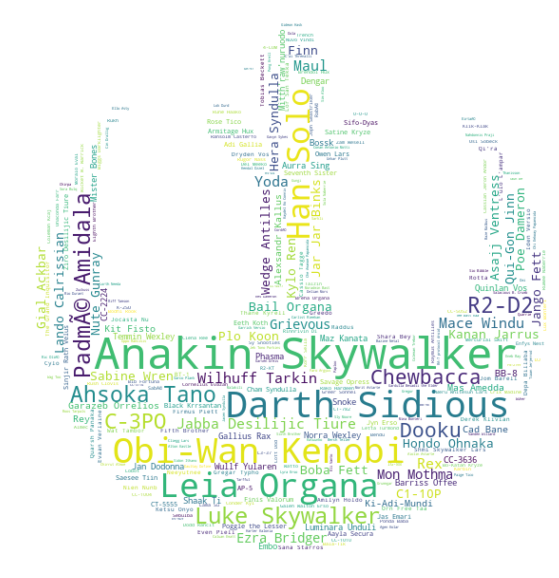

In [15]:
freqs = {}
for node in G:
    freqs[node] = G.degree(node) 
r2_mask = np.array(Image.open('./Transcripts/rebel.png', 'r'))
wordcloud = WordCloud(background_color="white", max_words=2000, mask=r2_mask)

wordcloud.generate_from_frequencies(freqs)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [16]:
print len(species)


5


# Sentiment for wikipage based on races


In [17]:
species = {}
for node in G.nodes :
    spe = G.nodes[node]["species"]
    if spe in species :
        species[spe].append(node)
    else :
        species[spe] = [node]
       

In [18]:
def tokenize(text):
    text = text.decode('ascii','ignore')

    # Remove all punctuation and numbers
    regexp = '[^\W]+'
    cleanTokens = re.findall(regexp, text)
    
    # Remove all words of length 1 and set lowercase
    cleanTokens = [w.lower() for w in cleanTokens if len(w) > 1]
    stopwords = nltk.corpus.stopwords.words('english')

    # Remove stopwords
    cleanTokens = [w for w in cleanTokens if w not in stopwords]
    
    return cleanTokens

def read_file(filename):
    with io.open('./'+filename, encoding='utf-8') as f:
        return f.read()

# Read word list and extract all the various categories
mt_word_list = read_file('Sentiment_Data_Set_S1.txt').splitlines()[3:]
sentiment_dict = {}

# Iterating over every word in list
for row in mt_word_list[1:]:
    cols = row.split("\t")
    word = cols[0]
    # cols[2] is the happiness score avg.
    sentiment_dict[word] = cols[2]

def get_sentiment(tokens):
    sentiment_sum = 0.0
    count = 0
    for token in tokens:
        if token in sentiment_dict:
            sentiment_sum += float(sentiment_dict[token]) # happiness avg
            count += 1
    if count == 0:
        return None
    avg_hap = sentiment_sum / float(count)
    return avg_hap

In [19]:
speciesSentiment = {}
for spe in species.keys() :
    speciesSentiment[spe] = 0
    for name in species[spe]:
        fileName = name.replace(" ", "_") + ".txt"
        text = open("./Wookiepediafiles/" + fileName, "r").read()
        speciesSentiment[spe] += get_sentiment(tokenize(text))
    speciesSentiment[spe] = speciesSentiment[spe]/len(species[spe]) 

    
sortedSentiment = sorted(speciesSentiment.items(), key=lambda kv: kv[1])
print sortedSentiment

LookupError: 
**********************************************************************
  Resource [93mstopwords[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('stopwords')
  [0m
  Searched in:
    - '/Users/Jacob/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
    - '/anaconda3/envs/py27/nltk_data'
    - '/anaconda3/envs/py27/share/nltk_data'
    - '/anaconda3/envs/py27/lib/nltk_data'
**********************************************************************
